# Interpolation to regular grid with KDTree

This method should only be used for basic visualization purposes, don't really trust the values that you get :)

In [1]:
import sys
sys.path.append("../")

from netCDF4 import Dataset, MFDataset
import pyfesom as pf
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline
from matplotlib import cm

Load mesh

In [2]:
meshpath  ='../../../../FESOM/mesh/'
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=True)

The *usepickle = True* and the pickle file (*pickle_mesh*) exists.
 We load the mesh from it.


Load some data

In [3]:
fl = MFDataset('../../../../FESOM/data/fesom.????.oce.mean.nc')

Here we define simple regular mesh. In principle curvilinear grids should also work.

In [4]:
lon = np.linspace(-180, 180, 1440)
lat = np.linspace(-90, 90, 720)
lons, lats = np.meshgrid(lon,lat)

Calculate mean temperature over all timesteps and extract surface temperature field.

In [5]:
level_data, elem_no_nan = pf.get_data(fl.variables['temp'][:,:].mean(axis=0),mesh,0)

For depth 0 model level -0.0 will be used


Nearest neighbor interpolation

In [6]:
nearest = pf.fesom2regular(level_data, mesh, lons, lats, how='nn')

Here: 

    level_data - result of the *get_data*
    mesh       - instance of the mesh
    lons/lats  - 2d coordinates of the target grid
    how        - ether "nn" (Nearest neighbor) or 'idist' (inverce distance)

Create filled contour map

In [7]:
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
x,y = m(lons,lats) # coordinates for target grid
x_tri, y_tri = m(mesh.x2, mesh.y2) # coordinates for original triangular grid

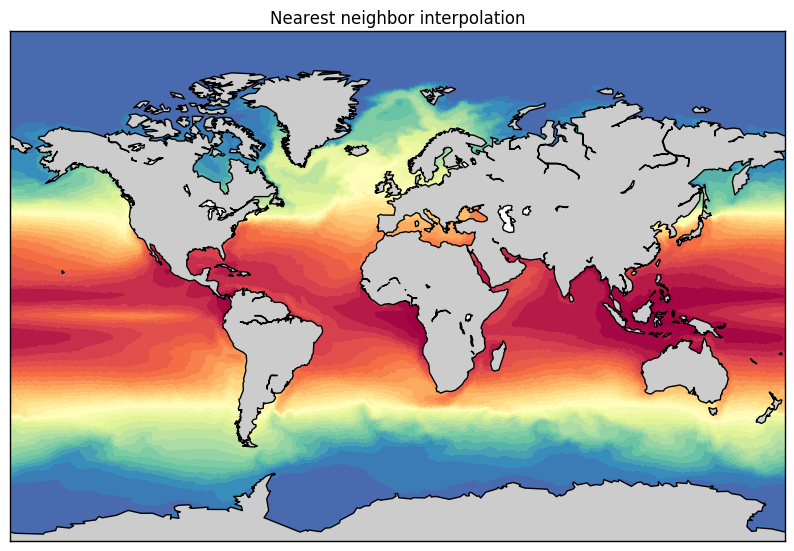

In [8]:
plt.figure(figsize=(10,7))
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents()

levels = np.arange(-3., 30., 1)
plt.contourf(x, y, nearest, levels = levels, \
                cmap=cm.Spectral_r, extend='both', zlev=0);
plt.title('Nearest neighbor interpolation');

We can make the same thing for the inverce distance interpolation. You can specify how many points you yould like to take in to account (*k*).

In [9]:
idist = pf.fesom2regular(level_data, mesh, lons, lats, how='idist', k=10)

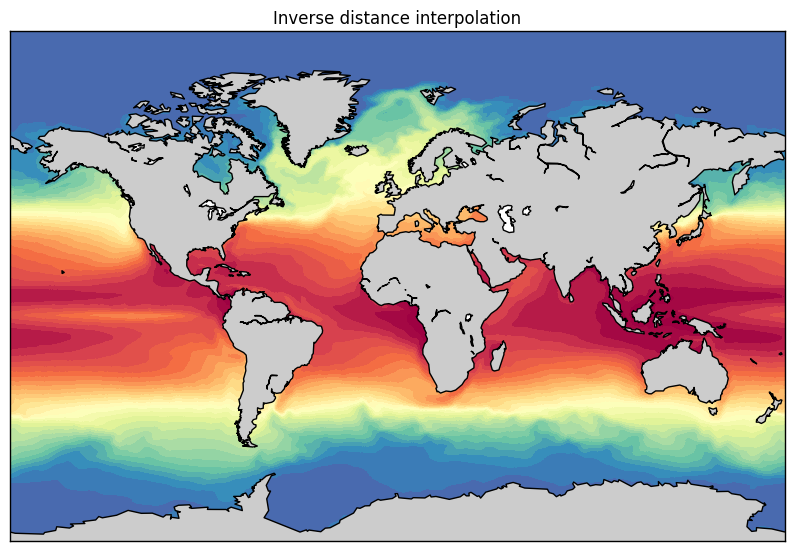

In [10]:
plt.figure(figsize=(10,7))
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents()

levels = np.arange(-3., 30., 1)
plt.contourf(x, y, idist, levels = levels, \
                cmap=cm.Spectral_r, extend='both', zlev=0);
plt.title('Inverse distance interpolation');

Comparison with plot on original grid and difference between interpolations.

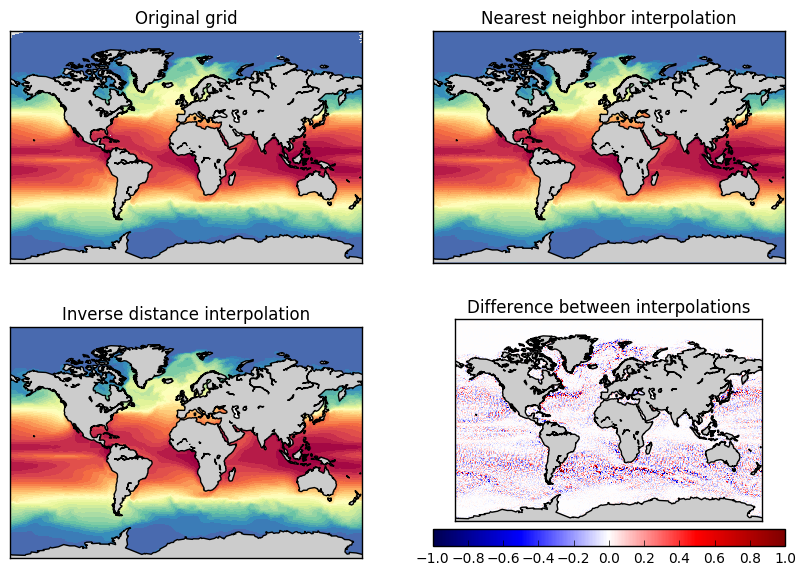

In [11]:
plt.figure(figsize=(10,7))
plt.subplot(221)
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents()

levels = np.arange(-3., 30., 1)
plt.tricontourf(x_tri, y_tri, elem_no_nan[::], level_data, levels = levels, \
                cmap=cm.Spectral_r, extend='both')
plt.title('Original grid');

plt.subplot(222)
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents()

levels = np.arange(-3., 30., 1)
plt.contourf(x, y, nearest, levels = levels, \
                cmap=cm.Spectral_r, extend='both', zlev=0);
plt.title('Nearest neighbor interpolation');

plt.subplot(223)
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents()

levels = np.arange(-3., 30., 1)
plt.contourf(x, y, idist, levels = levels, \
                cmap=cm.Spectral_r, extend='both', zlev=0);
plt.title('Inverse distance interpolation');

plt.subplot(224)
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents()

levels = np.arange(-2., 2.1, 0.1)
plt.pcolormesh(x, y, nearest-idist, \
                cmap=cm.seismic,  vmin=-1, vmax=1);
plt.title('Difference between interpolations');
plt.colorbar(orientation='horizontal', pad=0.03)

## Faster interpolation for multiple fields

The way function *fesom2regular* works is actually quite slow if you have to interpolate several fields (e.g. every timestep or every vertical level).

In [12]:
%%time
nearest_slow = pf.fesom2regular(level_data, mesh, lons, lats, how='nn')

CPU times: user 5.12 s, sys: 68 ms, total: 5.19 s
Wall time: 3.79 s


This is because the k-tree and indexes for interpolation are calculated every time in the function call. You can avoid it by precalculating indexes and providing distances and indexes directly. 

In [13]:
distances, inds = pf.create_indexes_and_distances(mesh, lons, lats,\
                                                k=10, n_jobs=2)

In [14]:
%%time
nearest_fast = pf.fesom2regular(level_data, mesh, lons, lats, distances=distances,\
                               inds=inds)

../pyfesom/regriding.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (distances==None) or (inds==None):


CPU times: user 208 ms, sys: 68 ms, total: 276 ms
Wall time: 283 ms


So you get 300 ms instead of 4 seconds. Not bad.

It's even more important when you calculate distance weighted interpolation with large numbers of neighbors.

In [15]:
%%time
idist_slow = pf.fesom2regular(level_data, mesh, lons, lats, how='idist', k=20)

CPU times: user 9.03 s, sys: 564 ms, total: 9.59 s
Wall time: 6.35 s


In [16]:
distances, inds = pf.create_indexes_and_distances(mesh, lons, lats,\
                                                k=20, n_jobs=2)

In [17]:
%%time
idist_fast = pf.fesom2regular(level_data, mesh, lons, lats, distances=distances,\
                               inds=inds)

CPU times: user 248 ms, sys: 328 ms, total: 576 ms
Wall time: 586 ms


## Interpolation over a region

One should not nessesarelly interpolate over the whole globe. When you would like to look at the specific region with higher (or lower) spatiall resolution, just generate the mesh for this region.

In [18]:
lon_small = np.linspace(-30, 30, 30)
lat_small = np.linspace(30, 70, 30)
lons_small, lats_small = np.meshgrid(lon_small,lat_small)

Interpolation with both methods

In [19]:
idist_small = pf.fesom2regular(level_data, mesh, lons_small, lats_small, how='idist', k=10)
nearest_small = pf.fesom2regular(level_data, mesh, lons_small, lats_small, how='nn', k=10)

And finally the figure:

In [20]:
ms = Basemap(projection='merc',llcrnrlat=30,urcrnrlat=70,\
            llcrnrlon=-30,urcrnrlon=30,lat_ts=20,resolution='l')

x_small, y_small = ms(lons_small, lats_small)
x2_small, y2_small = ms(mesh.x2, mesh.y2)

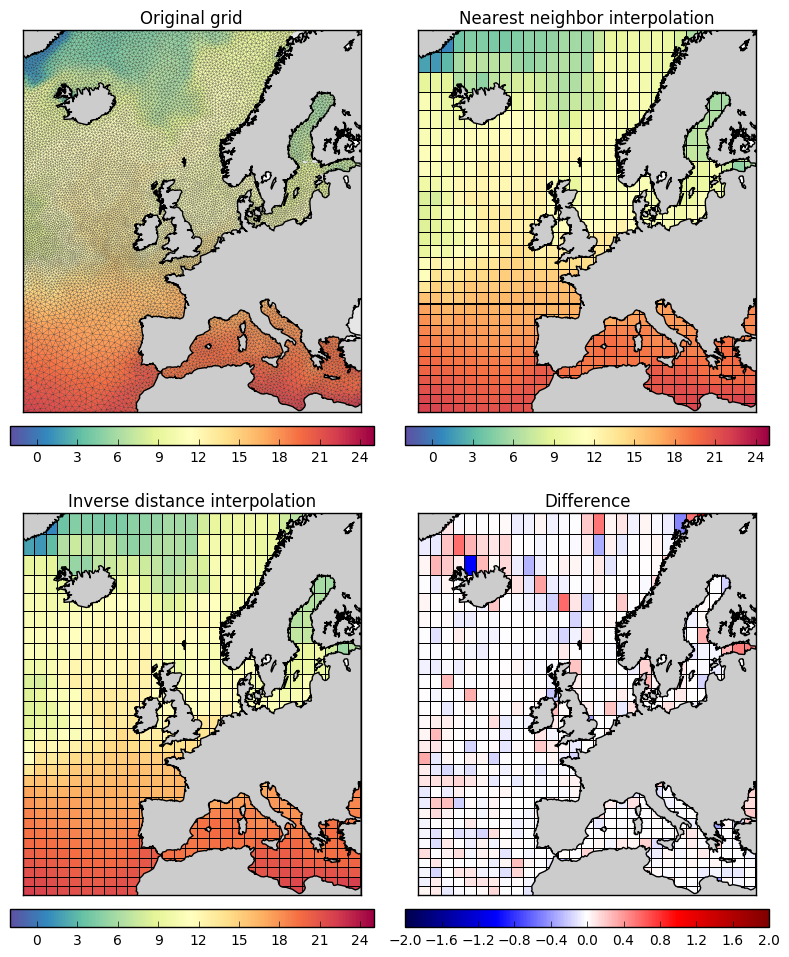

In [21]:
plt.figure(figsize=(8,10))

plt.subplot(221)
ms.drawmapboundary(fill_color='0.9')
ms.drawcoastlines()
ms.fillcontinents()

levels = np.arange(-2., 25., 1)
# plt.tricontourf(x2_small, y2_small, elem_no_nan[::], level_data, levels = levels, \
#                 cmap=cm.Spectral_r, extend='both')
plt.tripcolor(x2_small, y2_small, elem_no_nan, \
              level_data, \
              edgecolors='k',\
              lw = 0.1,
             cmap=cm.Spectral_r,
             vmin = -2,
             vmax = 25)

plt.title('Original grid');
plt.colorbar(orientation = 'horizontal', pad = 0.03)


plt.subplot(222)
ms.drawmapboundary(fill_color='0.9')
ms.drawcoastlines()
ms.fillcontinents()

plt.pcolormesh(x_small, y_small, nearest_small, \
                cmap=cm.Spectral_r, edgecolors='k', lw=0.01, vmin = -2, vmax=25 );
plt.title('Nearest neighbor interpolation');
plt.colorbar(orientation = 'horizontal', pad = 0.03)

plt.subplot(223)
ms.drawmapboundary(fill_color='0.9')
ms.drawcoastlines()
ms.fillcontinents()

plt.pcolormesh(x_small, y_small, idist_small, \
                cmap=cm.Spectral_r, edgecolors='k', lw=0.01, vmin = -2, vmax=25  );
plt.title('Inverse distance interpolation');
plt.colorbar(orientation = 'horizontal', pad = 0.03)

plt.subplot(224)
ms.drawmapboundary(fill_color='0.9')
ms.drawcoastlines()
ms.fillcontinents()

plt.pcolormesh(x_small, y_small, idist_small- nearest_small, \
                cmap=cm.seismic, edgecolors='k', lw=0.01, vmin = -2, vmax=2 );
plt.title('Difference');
plt.colorbar(orientation = 'horizontal', pad = 0.03)

plt.tight_layout()